In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from argparse import Namespace
from tqdm.notebook import tqdm
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import preds_targets_zn, PlottingContext, IO, get_rms, get_rms_no_outliers

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 0: train loss 6.12e+07, val loss 5.97e+07
Epoch 5000: train loss 7.25e+06, val loss 6.52e+06
Epoch 10000: train loss 5.16e+05, val loss 8.17e+05
Epoch 15000: train loss 1.90e+05, val loss 4.50e+05
Epoch 20000: train loss 1.38e+05, val loss 3.66e+05
Epoch 25000: train loss 1.11e+05, val loss 3.25e+05
Epoch 30000: train loss 9.53e+04, val loss 2.76e+05
Epoch 35000: train loss 8.54e+04, val loss 2.55e+05
Epoch 40000: train loss 7.87e+04, val loss 2.49e+05
Epoch 45000: train loss 7.30e+04, val loss 2.44e+05
Epoch 50000: train loss 6.70e+04, val loss 2.30e+05
Epoch 55000: train loss 6.22e+04, val loss 2.20e+05
Epoch 60000: train loss 5.66e+04, val loss 2.10e+05
Epoch 65000: train loss 5.14e+04, val loss 2.07e+05
Epoch 70000: train loss 4.96e+04, val loss 2.10e+05
Epoch 75000: train loss 4.46e+04, val loss 2.13e+05
Epoch 80000: train loss 4.32e+04, val loss 2.11e+05
Epoch 85000: train loss 3.78e+04, val loss 2.03e+05
Epoch 90000: train loss 3.45e+04, val loss 2.00e+05
Epoch 95000: trai

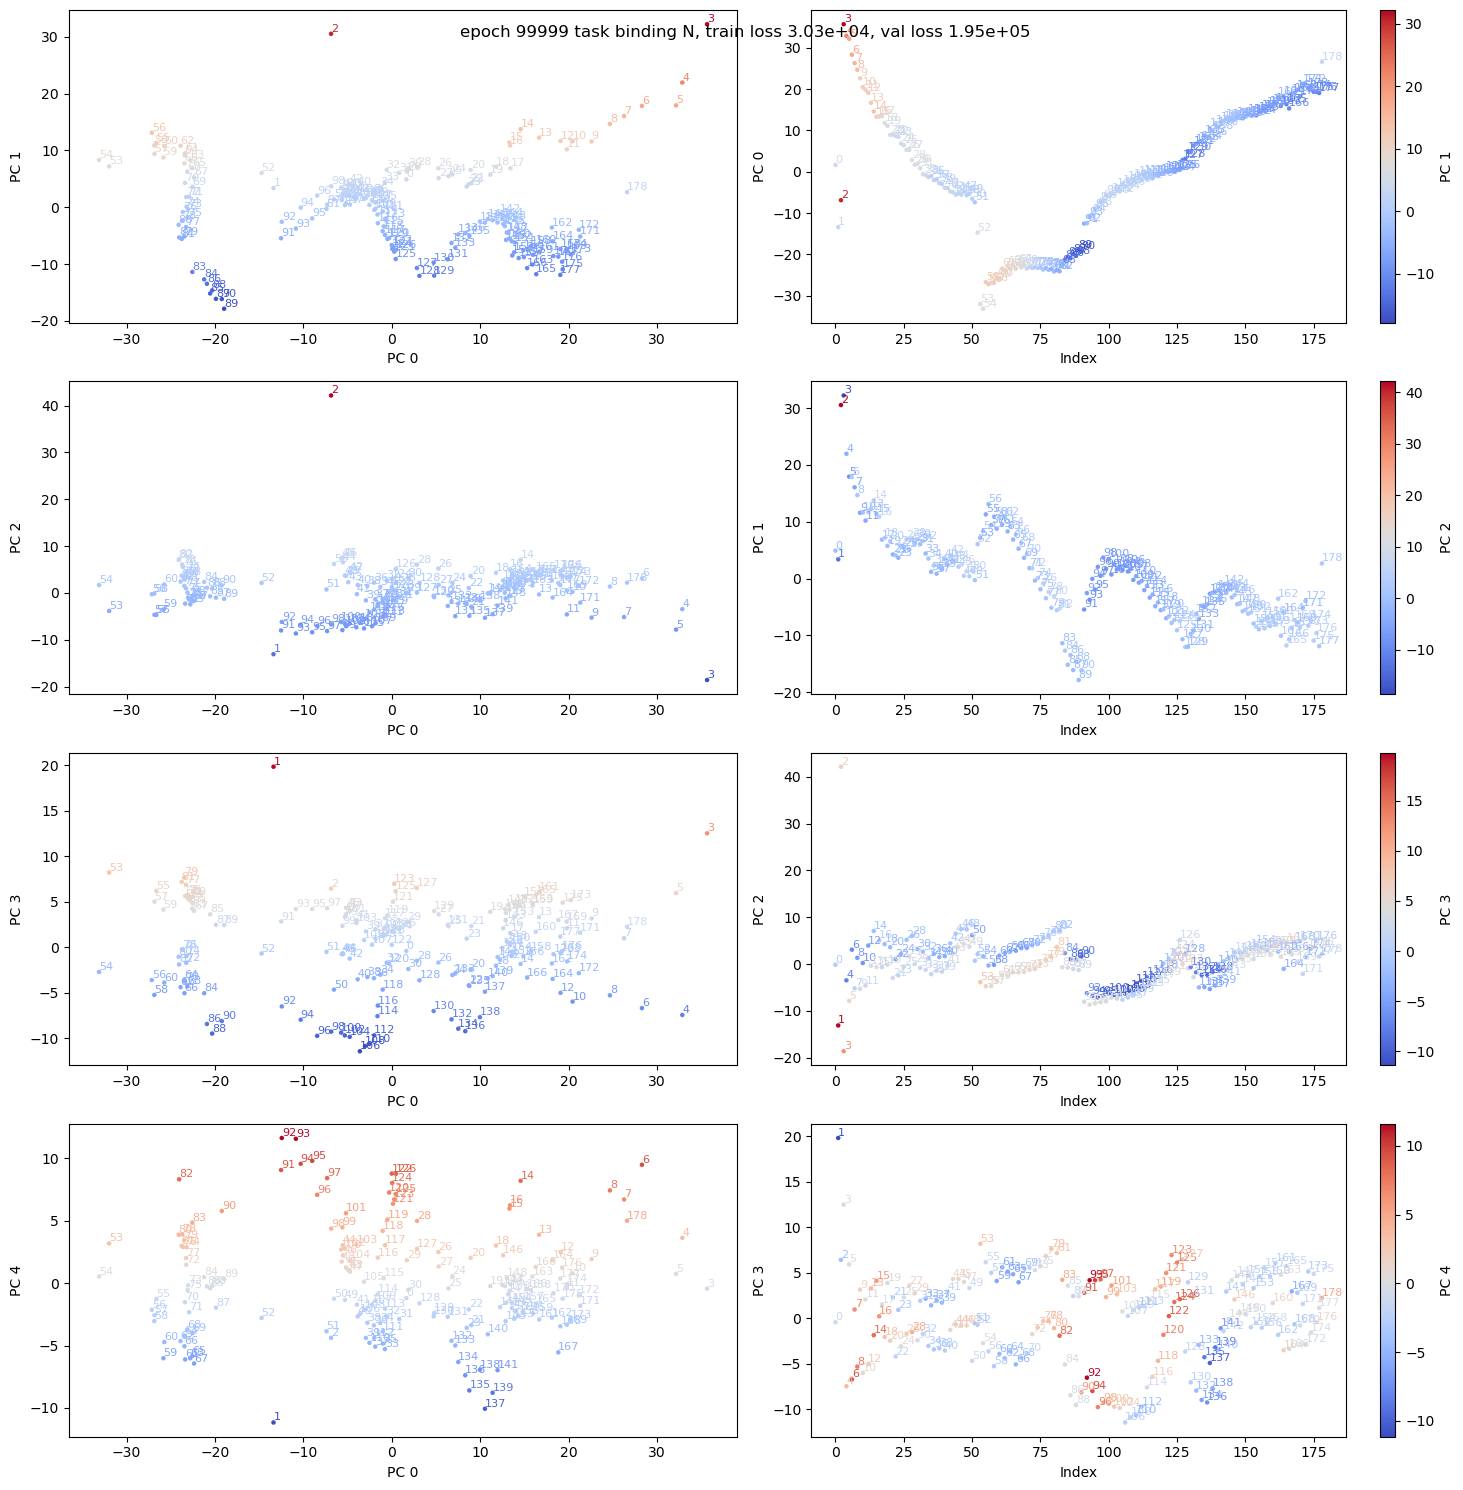

In [28]:
# loop
wd = "large"
for task in ["all"]:
    experiment_name = f"generalization_perf_small_models-wd{wd}/{task}"
    os.makedirs("experiments", exist_ok=True)
    os.makedirs(f"experiments/{experiment_name}", exist_ok=True)
    if task == "all":
        task_dict =         {
            "binding": 100,
            "z": 1,
            "n": 1,
            "radius": 0.02,
            "qa": 200,
            "qbm": 200,
            "qbm_n": 200,
            "qec": 200,
            "sn": 200,
            "sp": 200,
        }
    else:
        task_dict = {task: 100}
    args = {
        "DEPTH": 1,
        "DEV": (device:="cuda"),
        "EPOCHS": 100_000,
        "HIDDEN_DIM": 2048,
        "LR": 1e-3,
        "MODEL": "baseline",
        "SIGMOID_READOUT": "false",
        "TMS": "remove",
        "WD": {"small": 1e-8, "medium": 1e-4, "large": 1e-1}[wd],
        "LIPSCHITZ": "false",
        "DEV": "cuda",
        "TARGETS_CLASSIFICATION": {},
        "TARGETS_REGRESSION": task_dict,
        "TRAIN_SET": "random", # random, all_data, extrap_1, extrap_2, extrap_3
        "TRAIN_FRAC": 0.8,
        "BATCH_SIZE": 0.2,
        "LOG_TIMES": 10,
        "NUCLEI_GE": 0,
        "NUCLEI_HIGH_UNC": "keep",
        "PER_NUCLEON": "true",
        "SEED": 0,
    }

    args = Namespace(**args)

    # IO.save_args(args, f"experiments/{experiment_name}/args.yaml")

    data = prepare_nuclear_data(args)


    # setup data
    X_train = data.X[data.train_mask]
    y_train = data.y[data.train_mask]
    non_nan_targets = ~torch.isnan(y_train.view(-1))
    X_train = X_train[non_nan_targets]
    y_train = y_train[non_nan_targets]

    X_val = data.X[data.val_mask]
    y_val = data.y[data.val_mask]
    non_nan_targets = ~torch.isnan(y_val.view(-1))
    X_val = X_val[non_nan_targets]
    y_val = y_val[non_nan_targets]

    torch.manual_seed(1)
    new_model, optim_model = get_model_and_optim(data, args)

    # train the new model
    epochs = args.EPOCHS
    task_name = list(data.output_map.keys())[0]
    for epoch in (pbar:=tqdm(range(epochs))):
        batch = torch.randint(0, len(X_train), (int(len(X_train)*args.BATCH_SIZE),))
        optim_model.zero_grad()
        preds = new_model(X_train[batch])
        loss = torch.nn.functional.mse_loss(preds, y_train[batch])
        loss.backward()
        optim_model.step()
        if epoch % (epochs//20) == 0:
            with torch.no_grad():
                train_loss = torch.nn.functional.mse_loss(new_model(X_train), y_train)
                val_loss = torch.nn.functional.mse_loss(new_model(X_val), y_val)
                print(f"Epoch {epoch}: train loss {train_loss.item():.2e}, val loss {val_loss.item():.2e}")
            # embed = new_model.emb[1].detach().cpu().numpy()
            # PlottingContext.plot_embedding(embed, num_components=3); plt.show()
        pbar.set_description(f"Epoch {epoch}: {loss.item():.2e}")

    # let's take a look at our embeddings
    with torch.no_grad():
        final_train_loss = torch.nn.functional.mse_loss(new_model(X_train), y_train)
        final_val_loss = torch.nn.functional.mse_loss(new_model(X_val), y_val)
    nucleons = "ZN" 
    embed = new_model.emb[(nucleon:=1)].detach().cpu().numpy()
    fig = PlottingContext.plot_embedding(embed, num_components=5)
    fig.suptitle(f"epoch {epoch} task {task_name} {nucleons[nucleon]}, train loss {final_train_loss.item():.2e}, val loss {final_val_loss.item():.2e}")
    fig.savefig(f"experiments/{experiment_name}/embedding.png", dpi=300)
    fig.show()
    IO.save_args(args, f"experiments/{experiment_name}/args.yaml")
    torch.save(new_model.state_dict(), f"experiments/{experiment_name}/model.pt")

In [26]:
def rms(model, train=True):
    """compute binding RMS"""
    if train:
        X = X_train[X_train[:, 2] == 0]
        y = y_train[X_train[:, 2] == 0]
    else:
        X = X_val[X_val[:, 2] == 0]
        y = y_val[X_val[:, 2] == 0]
    with torch.no_grad():
        preds = model(X)
        rms = (preds - y).pow(2).mean().sqrt().item()
    return rms

rms(new_model, train=False)

60.73247146606445

In [18]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts

X = data.X 
y = data.y.view(-1)
mask = (X[:, 2] == 0) & ~torch.isnan(y)
X, y = X[mask], y[mask]

acts = get_penultimate_acts(new_model, X)

[7.5251305e-01 2.3173551e-01 1.1905126e-02 1.9702865e-03 1.1810804e-03
 3.4143703e-04 1.7740595e-04 6.0738257e-05 3.2069500e-05 2.0666494e-05]


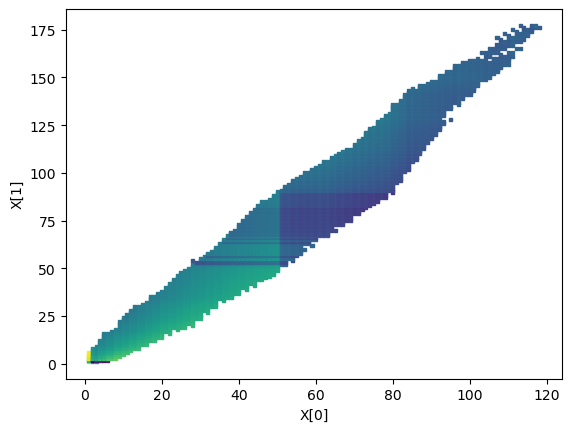

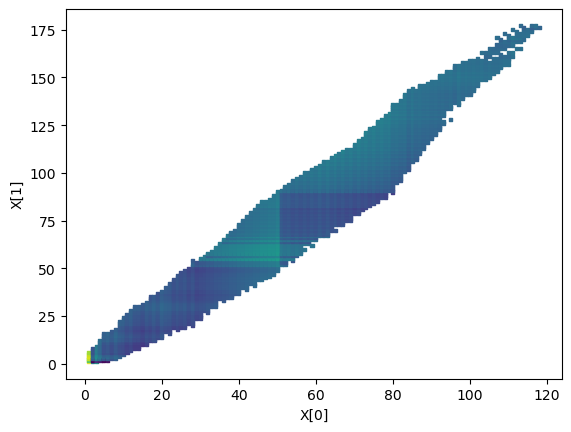

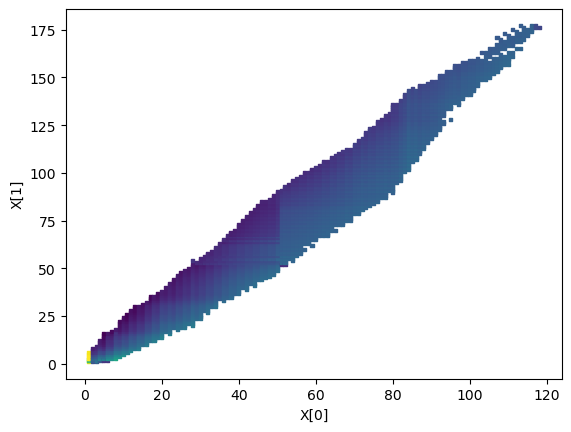

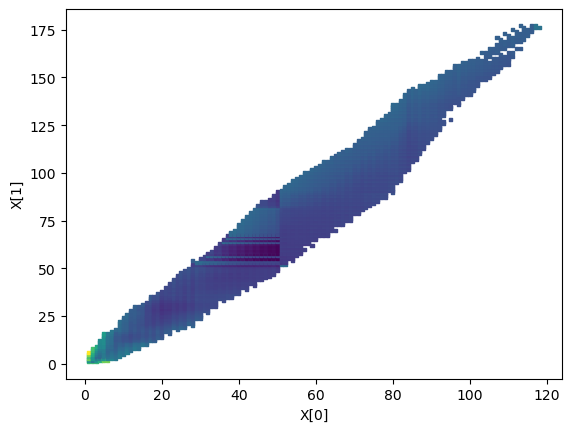

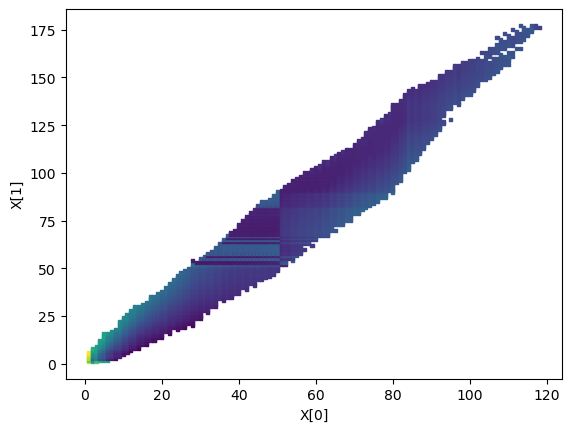

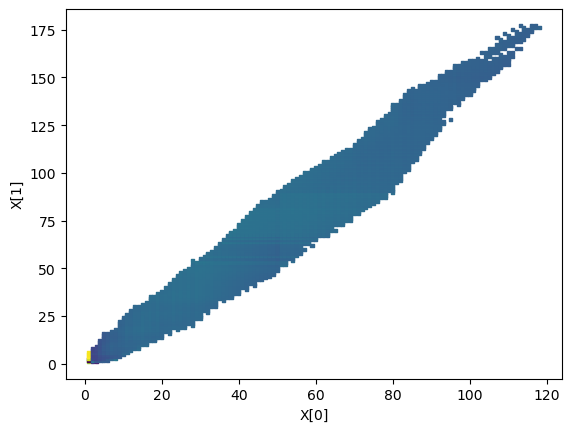

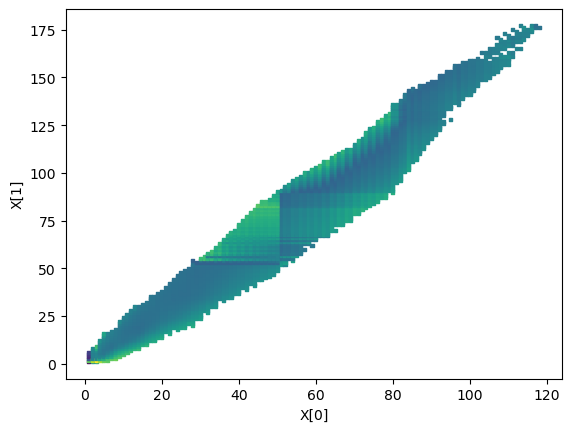

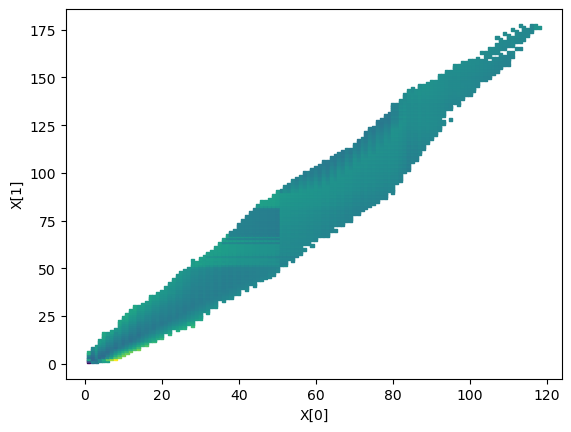

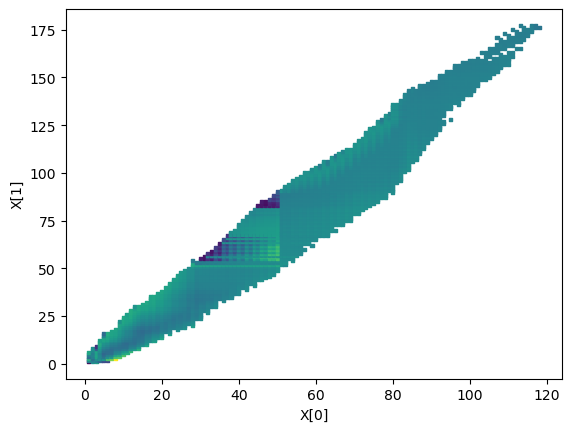

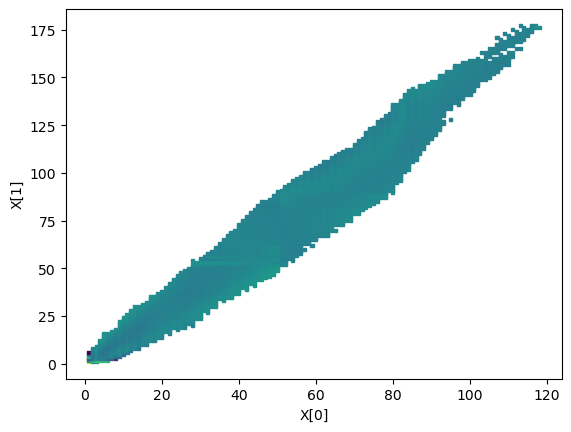

In [19]:
pca = PCA(n_components=10)
pca.fit(acts.detach().cpu().numpy())
acts_pca = pca.transform(acts.detach().cpu().numpy())
print(pca.explained_variance_ratio_)

# visualize PCs as a function of X[0] and X[1]
for i in range(pca.n_components_):
    plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=acts_pca[:, i], s=5, marker='s')
    plt.xlabel(f"X[0]")
    plt.ylabel(f"X[1]")
    plt.show()